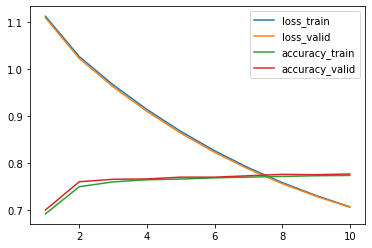

In [6]:
from torch import nn,optim
from torch.utils.data import TensorDataset,DataLoader
import pickle
import torch
import numpy as np

class tasou_neural_net(nn.Module):
    def __init__(self,inp,mid,out):
        super().__init__()
        self.fc=nn.Linear(inp,mid,bias=True)
        self.fc_mid=nn.ReLU()
        self.fc_out=nn.Linear(mid,out,bias=True)
        nn.init.xavier_normal_(self.fc.weight)
        nn.init.xavier_normal_(self.fc_out.weight)
    
    def forward(self,x):
        x=self.fc(x)
        x-self.fc_mid(x)
        x=self.fc_out(x)
        return x

def accuracy(pred,label):
    pred=torch.argmax(pred,dim=-1)
    leng=len(pred)
    return (pred==label).sum().item()/leng
    
model=tasou_neural_net(300,128,4)
device=torch.device("cuda"if torch.cuda.is_available() else "cpu")
model.to(device)

with open("train.pickle","rb") as tp:
    X_train=pickle.load(tp)
with open("train.label.pickle","rb") as tlp:
    Y_train=pickle.load(tlp)
with open("valid.pickle","rb") as tp:
    X_valid=pickle.load(tp)
with open("valid.label.pickle","rb") as tlp:
    Y_valid=pickle.load(tlp)

ave_loss=nn.CrossEntropyLoss()
dataset_train=TensorDataset(X_train.to(device),Y_train.to(device))
dl_train=DataLoader(dataset_train,batch_size=1024)
optimizer=torch.optim.SGD(model.parameters(),lr=0.1)

import time
import matplotlib.pyplot as plt
epoch=10
batch=1024
epo=[]
loss_train=[]
acc_train=[]
loss_valid=[]
acc_valid=[]
times=[]
for num in range(epoch):
    start=time.time()
    epo.append(num+1)
    for X,Y in dl_train:
        optimizer.zero_grad()
        pred=model(X)
        loss=ave_loss(pred,Y)
        loss.backward()
        optimizer.step()
    with torch.no_grad():
        loss_train.append(ave_loss(model(X_train.to(device)),Y_train.to(device)))
        acc_train.append(accuracy(model(X_train.cpu()),Y_train.cpu()))
        
        loss_valid.append(ave_loss(model(X_valid.to(device)),Y_valid.to(device)))
        acc_valid.append(accuracy(model(X_valid.cpu()),Y_valid.cpu()))
    times.append(time.time()-start)


plt.plot(epo,loss_train,label="loss_train")
plt.plot(epo,loss_valid,label="loss_valid")

plt.plot(epo,acc_train,label="accuracy_train")
plt.plot(epo,acc_valid,label="accuracy_valid")
plt.legend()